In [9]:
import os
import torch
import gymnasium as gym
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# ---------- DQN Definition ----------
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [10]:
# ---------- Evaluation Function ----------
def evaluate_model(model, env, episodes=10):
    rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = model(state_tensor)
                action = q_values.argmax().item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            total_reward += reward
            done = terminated or truncated
        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

In [11]:

# ---------- Setup ----------
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Using device: {device}")

env = gym.make("LunarLander-v2")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model_dir = "models"
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]

results = []

Using device: mps


In [12]:
# ---------- Evaluate Each Model ----------
for filename in model_files:
    model_path = os.path.join(model_dir, filename)
    try:
        print(f"🔍 Evaluating {filename}...")
        model = DQN(state_dim, action_dim).to(device)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()

        mean_reward, std_reward = evaluate_model(model, env, episodes=100)
        results.append((filename, mean_reward, std_reward))

        print(f"✅ {filename}: Avg Reward = {mean_reward:.2f} ± {std_reward:.2f}")
    except Exception as e:
        print(f"⚠️ Failed to evaluate {filename}: {e}")

🔍 Evaluating checkpoint_episode_1000.pth...
✅ checkpoint_episode_1000.pth: Avg Reward = -93.79 ± 27.38
🔍 Evaluating checkpoint_episode_3000.pth...
✅ checkpoint_episode_3000.pth: Avg Reward = 116.70 ± 112.50
🔍 Evaluating checkpoint_episode_3500.pth...
✅ checkpoint_episode_3500.pth: Avg Reward = 226.63 ± 51.44
🔍 Evaluating best_avg_model.pth...
✅ best_avg_model.pth: Avg Reward = 205.69 ± 106.58
🔍 Evaluating checkpoint_episode_500.pth...
✅ checkpoint_episode_500.pth: Avg Reward = -163.40 ± 32.83
🔍 Evaluating checkpoint_episode_1500.pth...
✅ checkpoint_episode_1500.pth: Avg Reward = -10.88 ± 21.40
🔍 Evaluating best_model.pth...
✅ best_model.pth: Avg Reward = 211.17 ± 94.71
🔍 Evaluating checkpoint_episode_2000.pth...
✅ checkpoint_episode_2000.pth: Avg Reward = 21.57 ± 65.86
🔍 Evaluating checkpoint_episode_0.pth...
✅ checkpoint_episode_0.pth: Avg Reward = -612.31 ± 163.13
🔍 Evaluating checkpoint_episode_2500.pth...
✅ checkpoint_episode_2500.pth: Avg Reward = 169.36 ± 97.84
🔍 Evaluating final

In [14]:
# ---------- Summary ----------
print("\n📊 Evaluation Summary:")
for fname, mean_r, std_r in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{fname:30s} --> Avg Reward: {mean_r:.2f} ± {std_r:.2f}")

env.close()



📊 Evaluation Summary:
checkpoint_episode_3500.pth    --> Avg Reward: 226.63 ± 51.44
best_model.pth                 --> Avg Reward: 211.17 ± 94.71
best_avg_model.pth             --> Avg Reward: 205.69 ± 106.58
final_model.pth                --> Avg Reward: 186.86 ± 129.02
checkpoint_episode_2500.pth    --> Avg Reward: 169.36 ± 97.84
checkpoint_episode_3000.pth    --> Avg Reward: 116.70 ± 112.50
checkpoint_episode_2000.pth    --> Avg Reward: 21.57 ± 65.86
checkpoint_episode_1500.pth    --> Avg Reward: -10.88 ± 21.40
checkpoint_episode_1000.pth    --> Avg Reward: -93.79 ± 27.38
checkpoint_episode_500.pth     --> Avg Reward: -163.40 ± 32.83
checkpoint_episode_0.pth       --> Avg Reward: -612.31 ± 163.13


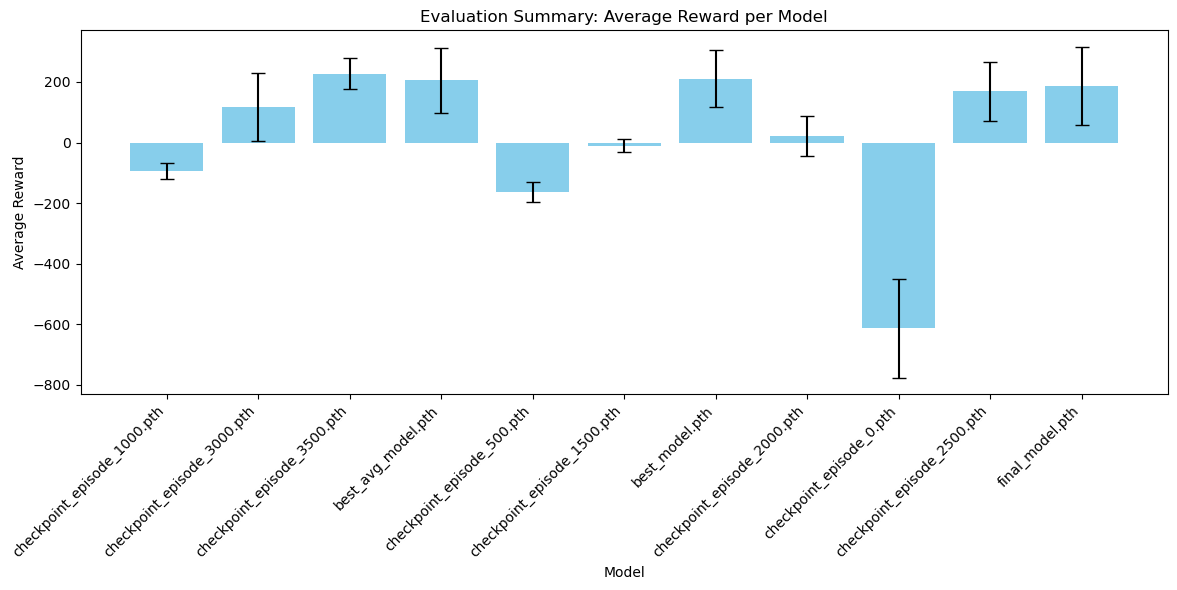

In [15]:
import matplotlib.pyplot as plt

# Assuming 'results' is a list of tuples: (filename, mean_reward, std_reward)
# Example: results = [('model1.pth', 120.5, 10.2), ('model2.pth', 130.1, 8.7), ...]

# Unpack results
model_names = [r[0] for r in results]
mean_rewards = [r[1] for r in results]
std_rewards = [r[2] for r in results]

plt.figure(figsize=(12, 6))
plt.bar(model_names, mean_rewards, yerr=std_rewards, capsize=5, color='skyblue')
plt.ylabel('Average Reward')
plt.xlabel('Model')
plt.title('Evaluation Summary: Average Reward per Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()